In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import shap
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
import pickle
from fastapi.encoders import jsonable_encoder
from fastapi.responses import HTMLResponse
import nest_asyncio
nest_asyncio.apply()

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

# Importation du fichier clients (fichier original nettoyé)
df = pd.read_csv('application_clean.csv', sep=';')

# Importation du fichier de données filtrées
df_filtered = pd.read_csv('df_filtered_p7.csv', sep=';', index_col='SK_ID_CURR')
df_filtered = df_filtered.drop('Unnamed: 0', axis=1)

data = df_filtered.copy().reset_index().drop('TARGET', axis=1)

In [3]:
# On ouvre le fichier pickel contenant les informations relatives à notre modèle
with open('modele_optimal.pickle', 'rb') as file:
    model = pickle.load(file)

y_train = model['y_train']
y_test = model['y_test']
X_train = model['X_train']
X_test = model['X_test']
y_pred_prob_test = model['y_pred_prob_test']
y_pred_prob_train = model['y_pred_prob_train']
model = model['trained_model']

In [4]:
# Ajout des probabilités aux données de test et d'entraînement
X_train['Proba'] = y_pred_prob_train
X_test['Proba'] = y_pred_prob_test

In [5]:
# On concatène nos df
data_prob = pd.concat([X_train, X_test])
data_prob = data_prob

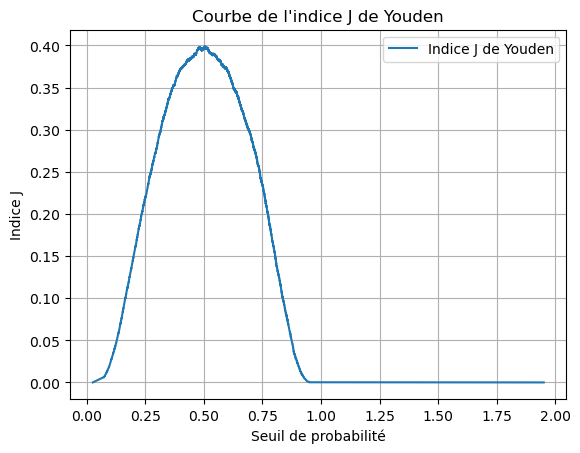

Seuil optimal : 0.5039874528512381
----------
L'accuracy score avec le seuil optimal est de : 0.703939195815626
Le score de précision avec le seuil optimal est de : 0.17146707931912344
Le score recall avec le seuil optimal est de : 0.693939393939394
Le score f1 avec le seuil optimal est de : 0.27498699115398473
Le score AUC avec le seuil optimal est de : 0.7651509403118864


In [6]:
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)

# Calcul de l'indice J de Youden pour chaque seuil
j_scores = tpr + (1 - fpr) - 1

# Affichage de la courbe de comparaison
plt.plot(thresholds, j_scores, label='Indice J de Youden')
plt.xlabel('Seuil de probabilité')
plt.ylabel('Indice J')
plt.title('Courbe de l\'indice J de Youden')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Trouver l'indice du seuil optimal qui minimise le FNR et maximise le TPR
optimal_threshold_index = np.argmax(j_scores)

# Seuil optimal
optimal_threshold = thresholds[optimal_threshold_index]

# Prédiction des classes avec le seuil optimal
y_pred_optimal = (y_pred_prob_test >= optimal_threshold).astype(int)

# Calcul des métriques de qualité de la classification avec le seuil optimal
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)
AUC_optimal = roc_auc_score(y_test, y_pred_prob_test)

# Affichage des résultats avec le seuil optimal
print("Seuil optimal :", optimal_threshold)
print('-'*10)
print("L'accuracy score avec le seuil optimal est de :", accuracy_optimal)
print("Le score de précision avec le seuil optimal est de :", precision_optimal)
print("Le score recall avec le seuil optimal est de :", recall_optimal)
print("Le score f1 avec le seuil optimal est de :", f1_optimal)
print("Le score AUC avec le seuil optimal est de :", AUC_optimal)

In [7]:
# On crée une fonction affichant la jauge de prédiction du seuil pour chaque client
def jauge(value):
    if value > optimal_threshold:
        color='red'
    else:
        color='green'
    fig = go.Figure(go.Indicator(
        domain = {'x': [0, 1], 'y': [0, 1]},
        value = value,
        mode = "gauge+number",
        title = {'text': "Probabilité prédite"},
        gauge = {'axis': {'range': [None, 1]}, 
                 'steps': [
                     {'range': [0, 0.5], 'color': "lightgray"},
                     {'range': [0.5, 1], 'color': "gray"}],
                 'threshold': {'line' : {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': optimal_threshold},
                 'bar' : {'color' : color}}))
    
    return fig

In [11]:
class ClientSearch(BaseModel):
    client_id: int

app = FastAPI()

@app.get("/clients/{client_id}")
async def get_client_info(client_id: int):
    # On récupère les informations du client à partir du DataFrame (df)
    client_info = df[df['SK_ID_CURR'] == client_id]
    
    if not client_info.empty:
        identifiant = int(client_info.iloc[0]['SK_ID_CURR'])
        genre = str(client_info.iloc[0]['CODE_GENDER'])
        age = int(client_info.iloc[0]['AGE'])
        profession = str(client_info.iloc[0]['OCCUPATION_TYPE'])
        revenu = float(client_info.iloc[0]['AMT_INCOME_TOTAL'])
        nb_enfants = int(client_info.iloc[0]['CNT_CHILDREN'])
        statut_fam = str(client_info.iloc[0]['NAME_FAMILY_STATUS'])
        
        type_contrat = str(client_info.iloc[0]['NAME_CONTRACT_TYPE'])
        montant_credit = float(client_info.iloc[0]['AMT_CREDIT'])
        
        # On récupère la probabilité client
        client_proba = float(data_prob.loc[data_prob['SK_ID_CURR'] == client_id, 'Proba'])
        
        # Comparaison de la probabilité prédite avec le seuil optimal
        if client_proba > optimal_threshold:
            position = "Refusé"
            position_color = "red"
        else:
            position = "Accepté"
            position_color = "green"

        # Dictionnaire avec les informations client
        response = {
            "Identifiant client:": identifiant,
            "Genre :": genre,
            "Age :": age,
            "Type de profession :": profession,
            "Revenu total :": revenu,
            "Nombre d'enfants:": nb_enfants,
            "Statut familial:": statut_fam,
            "Type de contrat:": type_contrat,
            "Montant du crédit:": montant_credit,
            "Score du client:": client_proba,
            "Position du client par rapport au seuil:": position
        }

        return response
    else:
        return {"message": "Client non trouvé"}
    
@app.get("/threshold")
async def get_threshold():
    return {"threshold": optimal_threshold}

@app.get("/features{client_id}")
async def get_features(client_id: int):
    # On récupère les informations du client à partir du df (data)
    return {"data_features": data}


if __name__ == "__main__":
    port = int(os.environ.get("PORT", 8000))
    uvicorn.run(app, host="0.0.0.0", port=port)

INFO:     Started server process [24388]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [24388]
